In [56]:
### Package Imports 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import dmba
from dmba import regressionSummary, gainsChart, liftChart
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import exhaustive_search
from dmba import stepwise_selection, forward_selection, backward_elimination
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import itertools
from sklearn.metrics.pairwise import haversine_distances
from math import radians

%matplotlib inline

In [5]:
rent = pd.read_csv('C:/Users/whitm/OneDrive/Documents/GitHub/Rent_Prediction/House_Rent_Dataset.csv')

### Data cleanup will entail splitting dates and addressing categorical variables
rent.head()

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner


## Pre-Processing

In [6]:
### Splitting train and test sets before preprocessing
train, test = train_test_split(rent, test_size = 0.3, random_state = 33)

### Train set predictors & Response
X_train = train.drop('Rent', axis = 1)
y_train = train['Rent']

### Test set predictors & Response
X_test = test.drop('Rent', axis = 1)
y_test = test['Rent']

print('\nTraining Set Length:', len(train))
print('\nTesting Set Length:', len(test))


Training Set Length: 3322

Testing Set Length: 1424


The dataset has been split 70/30 train/test and now has been split between predictors and reponse variables before moving into EDA and preprocessing. 

In [7]:
### There are no null values to fill
X_train.isna().sum()

Posted On            0
BHK                  0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

In [8]:
Floor_On = []
for i in range(0, len(X_train)):
    Floor_On.append(X_train.iloc[i].Floor[:2])
X_train[['Floor On']] = Floor_On


Floor_tot = []
for i in range(0, len(X_train)):
    Floor_tot.append(X_train.iloc[i].Floor[-2:])
X_train[['Floor total']] = Floor_tot

The above for loops extract the numerical values from the Floor predictor creating two predictors that represent the floors the individual is on and the total floors in the building. 

In the UK and India, the ground floor is referred to as the first floor in the U.S. and first floor in the UK and India is the second floor in the U.S..

Therefore, ground floor must be made into 0 and basement has been made into -1.

In [9]:
X_train[['Floor On']] = X_train[['Floor On']].replace('Gr', '0')
X_train[['Floor On']] = X_train[['Floor On']].replace('Up', '-1')
X_train[['Floor On']] = X_train[['Floor On']].replace('Lo', '-2')

X_train[['Floor total']] = X_train[['Floor total']].replace('nd', '0')

In [10]:
Floor_Ont = []
for i in range(0, len(X_test)):
    Floor_Ont.append(X_test.iloc[i].Floor[:2])
X_test[['Floor On']] = Floor_Ont


Floor_tott = []
for i in range(0, len(X_test)):
    Floor_tott.append(X_test.iloc[i].Floor[-2:])
X_test[['Floor total']] = Floor_tott

In [11]:
X_test[['Floor On']] = X_test[['Floor On']].replace('Gr', '0')
X_test[['Floor On']] = X_test[['Floor On']].replace('Up', '-1')
X_test[['Floor On']] = X_test[['Floor On']].replace('Lo', '-2')

X_train[['Floor total']] = X_train[['Floor total']].replace('nd', '0')

In [12]:
### Convert obj to datetime
X_train[['Posted On']] = pd.to_datetime(X_train['Posted On'])
X_train[['month']] = X_train['Posted On'].dt.month
X_train[['year']] = X_train['Posted On'].dt.year
X_train[['DOW']] = X_train['Posted On'].dt.dayofweek

X_test[['Posted On']] = pd.to_datetime(X_test['Posted On'])
X_test[['month']] = X_test['Posted On'].dt.month
X_test[['DOW']] = X_test['Posted On'].dt.dayofweek
X_test[['year']] = X_test['Posted On'].dt.year

X_train.head()

,Posted On,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,Floor On,Floor total,month,year,DOW
1698,2022-06-04,2,1000,3 out of 4,Super Area,Bommanahalli,Bangalore,Semi-Furnished,Bachelors/Family,2,Contact Owner,3,4,6,2022,5
3924,2022-05-10,2,200,Ground out of 1,Carpet Area,Dammaiguda,Hyderabad,Unfurnished,Bachelors,2,Contact Owner,0,1,5,2022,1
4375,2022-05-24,2,1200,2 out of 2,Super Area,"Beeramguda, Ramachandra Puram, NH 9",Hyderabad,Unfurnished,Bachelors,2,Contact Owner,2,2,5,2022,1
3910,2022-06-10,2,1140,3 out of 4,Super Area,Nizampet,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner,3,4,6,2022,4
3864,2022-05-16,2,1000,2 out of 3,Super Area,"Chromepet, GST Road",Chennai,Unfurnished,Bachelors/Family,2,Contact Owner,2,3,5,2022,0


In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3322 entries, 1698 to 2439
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Posted On          3322 non-null   datetime64[ns]
 1   BHK                3322 non-null   int64         
 2   Size               3322 non-null   int64         
 3   Floor              3322 non-null   object        
 4   Area Type          3322 non-null   object        
 5   Area Locality      3322 non-null   object        
 6   City               3322 non-null   object        
 7   Furnishing Status  3322 non-null   object        
 8   Tenant Preferred   3322 non-null   object        
 9   Bathroom           3322 non-null   int64         
 10  Point of Contact   3322 non-null   object        
 11  Floor On           3322 non-null   object        
 12  Floor total        3322 non-null   object        
 13  month              3322 non-null   int64         
 14  year 

In [14]:
X_train[['Floor On', 'Floor total']] = X_train[['Floor On', 'Floor total']].astype(int)

In [15]:
### Creating dummy variables for the train set
areatype_df = pd.get_dummies(X_train['Area Type'])
city_df = pd.get_dummies(X_train['City'])
furnish_df = pd.get_dummies(X_train['Furnishing Status'])
tenant_df = pd.get_dummies(X_train['Tenant Preferred'])
poc_df = pd.get_dummies(X_train['Point of Contact'])

### Creating dummy variables dataset
dummy_df = pd.concat([areatype_df, 
                      pd.concat([city_df, 
                                 pd.concat([furnish_df, poc_df], 
                                           axis = 1)], 
                                axis = 1)], 
                     axis = 1)


### Creating dummy variables for the test set
areatype_dft = pd.get_dummies(X_test['Area Type'])
city_dft = pd.get_dummies(X_test['City'])
furnish_dft = pd.get_dummies(X_test['Furnishing Status'])
tenant_dft = pd.get_dummies(X_test['Tenant Preferred'])
poc_dft = pd.get_dummies(X_test['Point of Contact'])

### Creating dummy variables dataset
dummy_dft = pd.concat([areatype_dft, 
                      pd.concat([city_dft, 
                                 pd.concat([furnish_dft, poc_dft], 
                                           axis = 1)], 
                                axis = 1)], 
                     axis = 1)

dummy_df.head()

,Built Area,Carpet Area,Super Area,Bangalore,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Furnished,Semi-Furnished,Unfurnished,Contact Agent,Contact Owner
1698,0,0,1,1,0,0,0,0,0,0,1,0,0,1
3924,0,1,0,0,0,0,1,0,0,0,0,1,0,1
4375,0,0,1,0,0,0,1,0,0,0,0,1,0,1
3910,0,0,1,0,0,0,1,0,0,0,1,0,0,1
3864,0,0,1,0,1,0,0,0,0,0,0,1,0,1


In [16]:
### concating the training set with the dummy variables 
X_train1 = pd.concat([X_train, dummy_df], axis = 1)

### concating the testing set with the dummy variables 
X_test1 = pd.concat([X_test, dummy_dft], axis = 1)

X_train1.head()

,Posted On,BHK,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,...,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Furnished,Semi-Furnished,Unfurnished,Contact Agent,Contact Owner
1698,2022-06-04,2,1000,3 out of 4,Super Area,Bommanahalli,Bangalore,Semi-Furnished,Bachelors/Family,2,...,0,0,0,0,0,0,1,0,0,1
3924,2022-05-10,2,200,Ground out of 1,Carpet Area,Dammaiguda,Hyderabad,Unfurnished,Bachelors,2,...,0,0,1,0,0,0,0,1,0,1
4375,2022-05-24,2,1200,2 out of 2,Super Area,"Beeramguda, Ramachandra Puram, NH 9",Hyderabad,Unfurnished,Bachelors,2,...,0,0,1,0,0,0,0,1,0,1
3910,2022-06-10,2,1140,3 out of 4,Super Area,Nizampet,Hyderabad,Semi-Furnished,Bachelors/Family,2,...,0,0,1,0,0,0,1,0,0,1
3864,2022-05-16,2,1000,2 out of 3,Super Area,"Chromepet, GST Road",Chennai,Unfurnished,Bachelors/Family,2,...,1,0,0,0,0,0,0,1,0,1


## EDA 

In [17]:
### Year will be a zero variance variable and therefore can be dropped
X_train1[['year']].value_counts()

year
2022    3322
dtype: int64

In [18]:
X_train1[['Area Type']].value_counts()

Area Type  
Super Area     1688
Carpet Area    1632
Built Area        2
dtype: int64

In [19]:
X_train1[['City']].value_counts()

City     
Mumbai       707
Chennai      624
Bangalore    613
Hyderabad    593
Delhi        424
Kolkata      361
dtype: int64

In [20]:
X_train1[['Tenant Preferred']].value_counts()

Tenant Preferred
Bachelors/Family    2392
Bachelors            586
Family               344
dtype: int64

#### Histogram for Continuous Variables

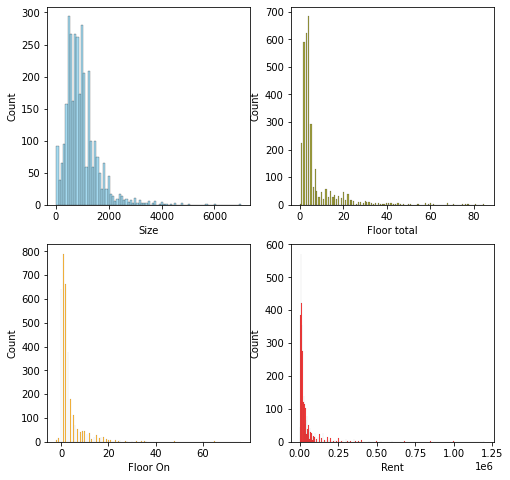

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
sns.histplot(X_train1["Size"] , color="skyblue", ax=axes[0,0])
sns.histplot(X_train1["Floor total"] , color="olive", ax=axes[0,1])
sns.histplot(X_train1["Floor On"] , color="orange", ax=axes[1,0])
sns.histplot(y_train , color="red", ax=axes[1,1])
plt.show()

#### Correlation Matrix

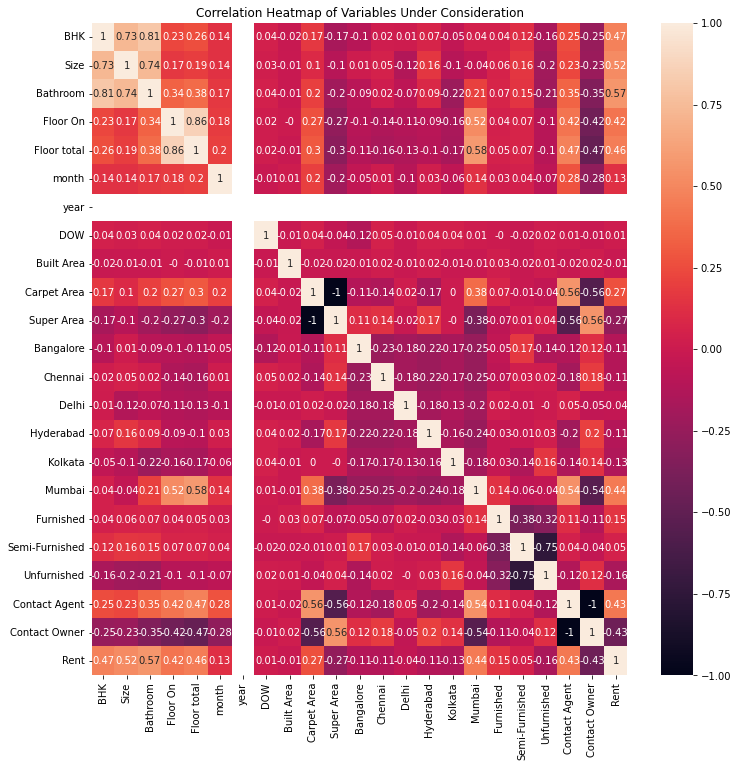

In [22]:
matrix = pd.concat([X_train1, y_train], axis = 1).corr().round(2)
plt.figure(figsize=(12,12))
sns.heatmap(matrix, annot=True)
plt.title('Correlation Heatmap of Variables Under Consideration')
plt.show()

#### Scatterplots

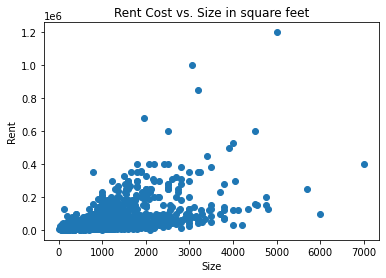

In [23]:
plt.scatter(x = X_train1['Size'], y = y_train)
plt.title('Rent Cost vs. Size in square feet')
plt.xlabel('Size')
plt.ylabel('Rent')
plt.show()

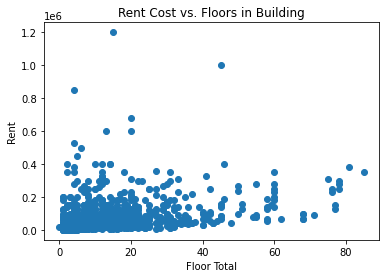

In [24]:
plt.scatter(x = X_train1['Floor total'], y = y_train)
plt.title('Rent Cost vs. Floors in Building')
plt.xlabel('Floor Total')
plt.ylabel('Rent')
plt.show()

In [25]:
Xmod_train = X_train1.drop(['Posted On','Floor','Area Type',
                           'Area Locality','City','Furnishing Status',
                           'Tenant Preferred','year','Point of Contact'], axis = 1)

Xmod_test = X_test1.drop(['Posted On','Floor','Area Type',
                           'Area Locality','City','Furnishing Status',
                           'Tenant Preferred','year','Point of Contact'], axis = 1)

Xmod_train.head()

,BHK,Size,Bathroom,Floor On,Floor total,month,DOW,Built Area,Carpet Area,Super Area,...,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Furnished,Semi-Furnished,Unfurnished,Contact Agent,Contact Owner
1698,2,1000,2,3,4,6,5,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3924,2,200,2,0,1,5,1,0,1,0,...,0,0,1,0,0,0,0,1,0,1
4375,2,1200,2,2,2,5,1,0,0,1,...,0,0,1,0,0,0,0,1,0,1
3910,2,1140,2,3,4,6,4,0,0,1,...,0,0,1,0,0,0,1,0,0,1
3864,2,1000,2,2,3,5,0,0,0,1,...,1,0,0,0,0,0,0,1,0,1


## Feature Extraction

In [26]:
### train model is built to iterate through the variables when performing stepwise regression
def train_model(variables):
    if len(variables) == 0:
        return None
    ### Building linear regression
    Model = LinearRegression()
    Model.fit(Xmod_train[variables], y_train)
    ### Returning the model fit with X amount of variables
    return Model

### Score model calculates the AIC of the models in order to choose the best variables based off of AIC
def score_model(Model, variables):
    if len(variables) == 0:
        return AIC_score(y_train, [y_train.mean()] * len(y_train), Model, df = 1)
    return AIC_score(y_train, Model.predict(Xmod_train[variables]), Model)

In [27]:
### Using Stepwise selection to extract the best variables
best_model, best_variables = stepwise_selection(Xmod_train.columns, train_model, score_model,
                                               verbose = True)
print(best_variables)

Variables: BHK, Size, Bathroom, Floor On, Floor total, month, DOW, Built Area, Carpet Area, Super Area, Bangalore, Chennai, Delhi, Hyderabad, Kolkata, Mumbai, Furnished, Semi-Furnished, Unfurnished, Contact Agent, Contact Owner
Start: score=82714.61, constant
Step: score=81423.82, add Bathroom
Step: score=80832.64, add Mumbai
Step: score=80444.13, add Size
Step: score=80365.04, add Delhi
Step: score=80309.73, add Floor total
Step: score=80277.42, add Hyderabad
Step: score=80256.92, add Furnished
Step: score=80251.74, add Chennai
Step: score=80250.67, add Floor On
Step: score=80249.90, add Bangalore
Step: score=80249.17, add month
Step: score=80249.17, unchanged None
['Bathroom', 'Mumbai', 'Size', 'Delhi', 'Floor total', 'Hyderabad', 'Furnished', 'Chennai', 'Floor On', 'Bangalore', 'month']


In [28]:
sub_X_train = Xmod_train[['Bathroom', 'Mumbai', 'Size', 
                         'Delhi', 'Floor total', 
                         'Hyderabad', 'Furnished', 
                         'Chennai', 'Floor On', 
                         'Bangalore', 'month']]

sub_X_test = Xmod_test[['Bathroom', 'Mumbai', 'Size', 
                       'Delhi', 'Floor total', 
                       'Hyderabad', 'Furnished', 
                       'Chennai', 'Floor On', 
                       'Bangalore', 'month']]

## Model Construction

### Random Forest Regressor

#### Full Dataset

In [29]:
rf_param_grid = {
    'max_depth': [5,10,15,20],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [10,20,30,40,50]
}
### Using GridSearch Cross Validation to identify best parameters
rf_search = GridSearchCV(RandomForestRegressor(random_state = 33), rf_param_grid, cv = 10, 
                          n_jobs = -1, return_train_score = True)

rf_search.fit(Xmod_train, y_train)
print('\nBest Score:', rf_search.best_score_)
print('\nGeneral Parameters:', rf_search.best_params_)


Best Score: 0.711700271955527

General Parameters: {'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [30]:
rrf_param_grid = {
    'max_depth': [16,17,18,19,20,21,22,23,24],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [17,18,19,20,21,22,23]
}
### Using GridSearch Cross Validation to identify best parameters
rrf_search = GridSearchCV(RandomForestRegressor(random_state = 33), rrf_param_grid, cv = 10, 
                          n_jobs = -1, return_train_score = True)

rrf_search.fit(Xmod_train, y_train)
print('\nBest Score:', rrf_search.best_score_)
print('\nGeneral Parameters:', rrf_search.best_params_)


Best Score: 0.7121383123335724

General Parameters: {'max_depth': 16, 'min_impurity_decrease': 0, 'min_samples_split': 19}


In [31]:
### Building Random Forest Model based off of parameters
rf = RandomForestRegressor(max_depth = 16, min_impurity_decrease = 0, 
                            min_samples_split = 19, random_state = 33).fit(Xmod_train, y_train)

### rsquared score
regressionSummary(y_test, rf.predict(Xmod_test))
print('\n')
print('r2 Score:', r2_score(y_test, rf.predict(Xmod_test)))


Regression statistics

                      Mean Error (ME) : 1416.7963
       Root Mean Squared Error (RMSE) : 104335.5787
            Mean Absolute Error (MAE) : 24838.9380
          Mean Percentage Error (MPE) : -55.6901
Mean Absolute Percentage Error (MAPE) : 83.1296


r2 Score: 0.04911695534327054


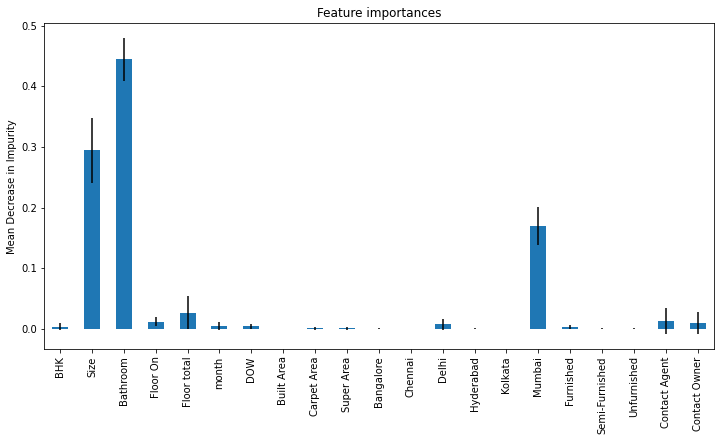

In [32]:
### Looking at the most important features for selection
feature_names = Xmod_train.columns
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(12,6))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean Decrease in Impurity")
plt.show()

#### Subset Dataset Modeling

In [33]:
srf_param_grid = {
    'max_depth': [5,10,15,20],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [10,20,30,40,50]
}
### Using GridSearch Cross Validation to identify best parameters
srf_search = GridSearchCV(RandomForestRegressor(random_state = 33), srf_param_grid, cv = 10, 
                          n_jobs = -1, return_train_score = True)

srf_search.fit(sub_X_train, y_train)
print('\nBest Score:', srf_search.best_score_)
print('\nGeneral Parameters:', srf_search.best_params_)


Best Score: 0.7049375775324402

General Parameters: {'max_depth': 20, 'min_impurity_decrease': 0, 'min_samples_split': 20}


In [34]:
srrf_param_grid = {
    'max_depth': [16,17,18,19,20,21,22,23,24],
    'min_impurity_decrease': [0,0.001,0.005,0.01],
    'min_samples_split': [17,18,19,20,21,22,23,24]
}
### Using GridSearch Cross Validation to identify best parameters
srrf_search = GridSearchCV(RandomForestRegressor(random_state = 33), srrf_param_grid, cv = 10, 
                           n_jobs = -1, return_train_score = True)

srrf_search.fit(sub_X_train, y_train)
print('\nBest Score:', srrf_search.best_score_)
print('\nGeneral Parameters:', srrf_search.best_params_)


Best Score: 0.7063986531111108

General Parameters: {'max_depth': 18, 'min_impurity_decrease': 0, 'min_samples_split': 24}


In [36]:
### Building Random Forest Model based off of parameters
sub_rf = RandomForestRegressor(max_depth = 18, min_impurity_decrease = 0, 
                               min_samples_split = 24, random_state = 33).fit(sub_X_train, y_train)

### rsquared score
regressionSummary(y_test, sub_rf.predict(sub_X_test))
print('\n')
print('r2 Score:', r2_score(y_test, sub_rf.predict(sub_X_test)))


Regression statistics

                      Mean Error (ME) : 2779.7643
       Root Mean Squared Error (RMSE) : 95180.5431
            Mean Absolute Error (MAE) : 13377.3773
          Mean Percentage Error (MPE) : -20.7413
Mean Absolute Percentage Error (MAPE) : 39.1585


r2 Score: 0.20866822807749974


### MLP Regressor

#### Full Dataset

In [45]:
### Initial gridsearch looking for activation // solver tune
mlp_param_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam','sgd'], 
    'learning_rate_init': [0.01, 0.05, 0.075, 0.1]
}

mlp_search = GridSearchCV(MLPRegressor(random_state = 33, batch_size = 32, max_iter = 2000), mlp_param_grid, 
                          cv = 10, n_jobs = -1)

mlp_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', mlp_search.best_params_)

C:\Users\whitm\anaconda3\envs\ads505\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [ 5.02643111e-001              nan  5.02131904e-001              nan
  5.11167952e-001              nan  5.13187164e-001              nan
 -7.24083684e-002 -5.49115234e-002 -7.01262525e-003              nan
 -1.48700839e-002              nan -1.92190004e-002              nan
 -1.16035210e-001 -2.77884295e-001 -2.05327107e-002              nan
 -4.01885716e-002              nan -1.47938981e-002              nan
  6.10125394e-001 -5.54141327e+104  5.91147547e-001 -1.65317965e+024
  5.94576370e-001 -1.16261414e+014  6.03580954e-001 -1.39525724e+002]
  category=UserWarning



General Parameters: {'activation': 'relu', 'learning_rate_init': 0.01, 'solver': 'adam'}


In [46]:
### GridSearching hyperparameters
rmlp_param_grid = {
    'hidden_layer_sizes': [20, 30, 40, 50, 60, 70, 80, 90, 100],
    'alpha': [0.0001, 0.001, 0.005, 0.01, 0.1]
}

rmlp_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', 
                                       learning_rate_init = 0.01, batch_size = 32, 
                                       max_iter = 2000, random_state = 33), 
                           rmlp_param_grid, cv = 10, n_jobs = -1)

rmlp_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', rmlp_search.best_params_)


General Parameters: {'alpha': 0.01, 'hidden_layer_sizes': 40}


In [47]:
### Final GridSearch for minute adjustments
cls_param_grid = {
    'hidden_layer_sizes': [35,36,37,38,39,40,41,42,43,44]
}

cls_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', alpha = 0.01, 
                                       learning_rate_init = 0.01, batch_size = 32, 
                                       max_iter = 2000, random_state = 33), 
                          cls_param_grid, cv = 10, n_jobs = -1)

cls_search.fit(Xmod_train, y_train)
print('\nGeneral Parameters:', cls_search.best_params_)


General Parameters: {'hidden_layer_sizes': 40}


In [51]:
### Building the final subset predictor model
mlp = MLPRegressor(activation = 'relu', solver = 'adam', 
                   alpha = 0.01, hidden_layer_sizes = 40, 
                   batch_size = 32, max_iter = 2000, 
                   random_state = 33).fit(Xmod_train, y_train)


print('\nr2 Score:', r2_score(y_test, mlp.predict(Xmod_test)))
print('\n')
regressionSummary(y_test, mlp.predict(Xmod_test))


r2 Score: 0.1217847755815582



Regression statistics

                      Mean Error (ME) : 6600.3476
       Root Mean Squared Error (RMSE) : 100269.6175
            Mean Absolute Error (MAE) : 22315.8403
          Mean Percentage Error (MPE) : -23.8556
Mean Absolute Percentage Error (MAPE) : 64.2669


#### Stepwise Subset

In [52]:
### Initial gridsearch looking for activation // solver tune
smlp_param_grid = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['adam','sgd'], 
    'learning_rate_init': [0.01, 0.05, 0.075, 0.1]
}

smlp_search = GridSearchCV(MLPRegressor(random_state = 33, batch_size = 32, max_iter = 2000), smlp_param_grid, 
                          cv = 10, n_jobs = -1)

smlp_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', smlp_search.best_params_)

C:\Users\whitm\anaconda3\envs\ads505\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [ 5.09619670e-001              nan  4.86983317e-001              nan
  5.01619261e-001              nan  4.71781644e-001              nan
 -1.14589243e-001 -1.29895023e-001 -6.41154060e-003              nan
 -1.14302200e-002              nan -2.20767880e-002              nan
 -1.13938689e-001 -1.25651746e-001 -7.63533770e-002              nan
 -2.80809767e-002              nan -1.77898367e-002              nan
  6.59787492e-001 -6.18976109e+077  5.64086898e-001 -1.16323610e+114
  5.53439675e-001 -3.57809097e-003  5.43357012e-001 -4.54359189e+010]
  category=UserWarning



General Parameters: {'activation': 'relu', 'learning_rate_init': 0.01, 'solver': 'adam'}


In [53]:
### GridSearching hyperparameters
srmlp_param_grid = {
    'hidden_layer_sizes': [20, 30, 40, 50, 60, 70, 80, 90, 100],
    'alpha': [0.0001, 0.001, 0.005, 0.01, 0.1]
}

srmlp_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', 
                                       learning_rate_init = 0.01, batch_size = 32, 
                                       max_iter = 2000, random_state = 33), 
                           srmlp_param_grid, cv = 10, n_jobs = -1)

srmlp_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', srmlp_search.best_params_)


General Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': 100}


In [54]:
### Final GridSearch for minute adjustments
scls_param_grid = {
    'hidden_layer_sizes': [95,96,97,98,99,100,101,102,103,104]
}

scls_search = GridSearchCV(MLPRegressor(activation = 'relu', solver = 'adam', alpha = 0.001, 
                                        learning_rate_init = 0.01, batch_size = 32, 
                                        max_iter = 2000, random_state = 33), 
                           scls_param_grid, cv = 10, n_jobs = -1)

scls_search.fit(sub_X_train, y_train)
print('\nGeneral Parameters:', scls_search.best_params_)


General Parameters: {'hidden_layer_sizes': 100}


In [55]:
### Building the final subset predictor model
sub_mlp = MLPRegressor(activation = 'relu', solver = 'adam', 
                       alpha = 0.01, hidden_layer_sizes = 100, 
                       batch_size = 32, max_iter = 2000, 
                       random_state = 33).fit(sub_X_train, y_train)


print('\nr2 Score:', r2_score(y_test, sub_mlp.predict(sub_X_test)))
print('\n')
regressionSummary(y_test, sub_mlp.predict(sub_X_test))


r2 Score: 0.17370683522289532



Regression statistics

                      Mean Error (ME) : 2369.5734
       Root Mean Squared Error (RMSE) : 97260.3790
            Mean Absolute Error (MAE) : 17093.8380
          Mean Percentage Error (MPE) : -17.8573
Mean Absolute Percentage Error (MAPE) : 52.8787
